# `app.py`

In [84]:
import os
import sys
import collections
import pandas as pd
import mudata

sys.path.append("/cellar/users/aklie/opt/gene_program_evaluation/app")
from utils import load_config
from parse import parse
from plot import heatmap, scatterplot

def load_and_parse_data(
        path_mdata,
        path_evaluation_outs,
        data_key="rna",
        perturbation_association_stratification_key=None,
        motif_enrichment_stratification_key=None,
    ):
        try:
            # Load mdata
            mdata = mudata.read_h5mu(path_mdata)
            mdata.mod = collections.OrderedDict(sorted(mdata.mod.items()))
            
            # Parse data
            results = parse(
                mdata, 
                path_evaluation_outs, 
                data_key,
                perturbation_association_stratification_key=perturbation_association_stratification_key,
                motif_enrichment_stratification_key=motif_enrichment_stratification_key,
            )
            
            # Add obs data from data_key
            obs = mdata[data_key].obs.reset_index()
            obs.columns = ["barcode"] + list(obs.columns[1:])
            results["obs"] = obs
            
            # Add obsm data
            obsms = {}
            for obsm_key in mdata[data_key].obsm:
                cols = [f"{obsm_key}_{i}" for i in range(2)]
                rows = mdata[data_key].obs_names
                df = pd.DataFrame(mdata[data_key].obsm[obsm_key][:, :2], columns=cols, index=rows)
                obsms[obsm_key] = df
            results["obsms"] = obsms

            # Return results
            return results

        except Exception as e:
            print(f"Could not load mdata: {e}")
            sys.exit(1)

path_config = "/cellar/users/aklie/opt/gene_program_evaluation/examples/report/iPSC_EC/cNMF/cNMF_30/report.yaml"
config = load_config(path_config)

# Parse config for paths
path_evaluation_outs = config["path_evaluation_outs"]
path_mdata = config["path_mdata"]
path_evaluation_config = config["path_evaluation_config"]
path_report_out = config["path_report_out"]

# Parse config for other parameters
data_key = config["data_key"]
categorical_keys = config["categorical_keys"] if config["categorical_keys"] else []
continuous_keys = config["continuous_keys"] if config["continuous_keys"] else []
annotations_loc = config["annotations_loc"]

# Load evaluation config
evaluation_config = load_config(path_evaluation_config)
perturbation_association_stratification_key = evaluation_config["perturbation_association"]["groupby_key"]
motif_enrichment_stratification_key = evaluation_config["motif_enrichment"]["groupby_key"]

# Log configuration
for key, value in config.items():
    print(f"{key}: {value}")

# Load and parse data
results = load_and_parse_data(
    path_mdata=path_mdata,
    path_evaluation_outs=path_evaluation_outs,
    data_key=data_key,
    perturbation_association_stratification_key=perturbation_association_stratification_key,
    motif_enrichment_stratification_key=motif_enrichment_stratification_key,
)

# Add in path_report_out to results
results['path_evaluation_outs'] = path_evaluation_outs
results['path_mdata'] = path_mdata
results['evaluation_config'] = evaluation_config
results['path_report_out'] = path_report_out
results['data_key'] = data_key
results['categorical_keys'] = categorical_keys
results['continuous_keys'] = continuous_keys
results['annotations_loc'] = annotations_loc
results['perturbation_association_stratification_key'] = perturbation_association_stratification_key
results['motif_enrichment_stratification_key'] = motif_enrichment_stratification_key

path_evaluation_outs: ['/cellar/users/aklie/opt/gene_program_evaluation/examples/evaluation/iPSC_EC/cNMF/cNMF_30']
path_evaluation_config: /cellar/users/aklie/opt/gene_program_evaluation/examples/evaluation/iPSC_EC/cNMF/cNMF_30/evaluation_pipeline.yml
path_mdata: /cellar/users/aklie/opt/gene_program_evaluation/examples/evaluation/iPSC_EC/cNMF/cNMF_30/cNMF_30.h5mu
path_report_out: /cellar/users/aklie/opt/gene_program_evaluation/examples/report/iPSC_EC/cNMF/cNMF_30
prog_keys: ['cNMF_30']
data_key: rna
categorical_keys: ['sample', 'leiden']
continuous_keys: ['n_counts']
annotations_loc: annotations.csv


/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning:

The dtype argument is deprecated and will be removed in late 2024.

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning:

The dtype argument is deprecated and will be removed in late 2024.

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/mudata/_core/mudata.py:479: UserWarning:

var_names are not unique. To make them unique, call `.var_names_make_unique`.



Gene/guide: gene, Stratification key: sample, Level key: sample_D1
Gene/guide: gene, Stratification key: sample, Level key: sample_D2
Gene/guide: gene, Stratification key: sample, Level key: D0
Gene/guide: gene, Stratification key: sample, Level key: sample_D3
Library: Reactome_2022, Method: fisher
Library: GO_Biological_Process_2023, Method: fisher
Database: OT_GWAS, Method: fisher
E_P_type: enhancer, Database: test, Test type: pearsonr, Stratification key: sample, Level key: sample_D2
E_P_type: enhancer, Database: test, Test type: pearsonr, Stratification key: sample, Level key: sample_D3
E_P_type: enhancer, Database: test, Test type: pearsonr, Stratification key: sample, Level key: D0
E_P_type: enhancer, Database: test, Test type: pearsonr, Stratification key: sample, Level key: sample_D1


# Covariate association

## Program-covariate heatmap

In [85]:
categorical_association_posthoc = results["categorical_associations_posthoc"][config["prog_keys"][0]][categorical_keys[0]]

In [95]:
# Grab columns with stat in it
categorical_association_posthoc_stat = categorical_association_posthoc.filter(like="stat")
new_cols = categorical_association_posthoc_stat.columns.str.split(f"{categorical_keys[0]}_", n=1).str[1].str.rstrip("_stat").str.rsplit('_', n=1).str[0]
method = categorical_association_posthoc_stat.columns.str.split(f"{categorical_keys[0]}_", n=1).str[1].str.rstrip("_stat").str.rsplit('_', n=1).str[1].unique()[0]
categorical_association_posthoc_stat.columns = new_cols
categorical_association_posthoc_stat.index = categorical_association_posthoc["program_name"].astype(str).values
plot_data = categorical_association_posthoc_stat.T

In [96]:
fig = heatmap(
    data=plot_data,
    x_name="Program",
    y_name=categorical_keys[0],
    z_name=method,
    title="",
    xaxis_title="Program",
    yaxis_title=categorical_keys[0],
    colorbar_title=method,
    hovertemplate=f'<b>{categorical_keys[0]}: %{{y}}</b><br><b>Program: %{{x}}</b><br><b>{method}: %{{z}}</b>',
    zmin=-1,
    zmax=1,
    zmid=0,
)
fig.show()

## Categorical association volcano plot

In [97]:
# Grab columns with stat in it
categorical_association_posthoc_stat = categorical_association_posthoc.filter(like="stat")
categorical_association_posthoc_stat.index = categorical_association_posthoc["program_name"].astype(str).values
categorical_association_posthoc_stat

,sample_D0_pearsonr_stat,sample_sample_D1_pearsonr_stat,sample_sample_D2_pearsonr_stat,sample_sample_D3_pearsonr_stat
0,0.870169,-0.412455,-0.345800,-0.512979
1,-0.458007,-0.270776,-0.255153,0.732122
2,0.325260,0.072408,-0.073127,-0.354213
3,0.340553,0.125554,-0.130546,-0.372004
4,0.451908,0.031683,-0.229251,-0.365807
5,-0.388457,0.840549,-0.237996,-0.343107
6,0.261422,0.186126,-0.151744,-0.352161
7,0.622893,-0.252181,-0.245848,-0.377141
8,0.342130,0.102100,-0.149152,-0.340050
9,-0.409822,-0.252858,-0.224408,0.666162


In [104]:
# Take the max of the stat across columns
categorical_association_posthoc_stat_max = categorical_association_posthoc_stat.abs().max(axis=1)
plot_data = categorical_association_posthoc_stat_max.reset_index().rename(columns={"index": "program_name", 0: method}).sort_values(method, ascending=False)
plot_data

,program_name,pearsonr
0,0,0.870169
5,5,0.840549
1,1,0.732122
11,11,0.673134
17,17,0.669821
9,9,0.666162
16,16,0.658611
14,14,0.636916
7,7,0.622893
10,10,0.605691


In [106]:
plot_data["pearsonr"]

0     0.870169
5     0.840549
1     0.732122
11    0.673134
17    0.669821
9     0.666162
16    0.658611
14    0.636916
7     0.622893
10    0.605691
22    0.589650
13    0.579582
26    0.526424
12    0.512747
20    0.511167
4     0.451908
21    0.405839
3     0.372004
27    0.366519
24    0.365454
2     0.354213
19    0.353173
6     0.352161
25    0.349155
8     0.342130
28    0.282388
18    0.269874
29    0.258225
15    0.232837
23    0.200142
Name: pearsonr, dtype: float64

In [107]:
def scatterplot(
    data: pd.DataFrame,
    x_column: str,
    y_column: str,
    title: str,
    sorted: bool = True,
    x_axis_title: str = None,
    y_axis_title: str = None,
    cumulative: bool = False,
    show_xaxis_labels: bool = False,
    colors: list = None,  # New parameter for optional colors
    size: int = 1
):
    """Create a scatter plot layout in Dash using Plotly.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the data for the plot.
    x_column : str
        The column to use for the x-axis.
    y_column : str
        The column to use for the y-axis.
    title : str
        Title of the plot.
    x_axis_title : str, optional
        Title for the x-axis.
    y_axis_title : str, optional
        Title for the y-axis.
    cumulative : bool, optional
        Whether to plot cumulative values.
    show_xaxis_labels : bool, optional
        Whether to show labels on the x-axis.
    colors : list, optional
        List of colors corresponding to each point in the plot.

    Returns
    -------
    go.Figure
        A Plotly Figure containing the scatter plot.
    """
    # Compute cumulative values
    if cumulative:
        data[y_column] = data[y_column].cumsum()

    # Sort
    x_data = data.sort_values(y_column, ascending=cumulative)[x_column] if sorted else data[x_column]
    y_data = data.sort_values(y_column, ascending=cumulative)[y_column] if sorted else data[y_column]

    # Plot
    fig = go.Figure(
        data=go.Scattergl(
            x=x_data,
            y=y_data,
            mode='markers',
            marker=dict(
                color=colors if colors is not None else 'blue',  # Use passed colors or default to blue
                size=size
            )
        )
    )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title=x_axis_title if x_axis_title else x_column,
        yaxis_title=y_axis_title if y_axis_title else y_column,
        xaxis=dict(showticklabels=show_xaxis_labels),
        plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    )
    
    return fig

In [108]:
scatterplot(
    data=plot_data,
    x_column="program_name",
    y_column=method,
    title="",
    x_axis_title="Program",
    y_axis_title=method,
    sorted=True,
    cumulative=False,
    show_xaxis_labels=False,
    colors=None,
    size=8,
)

In [ ]:
new_cols = categorical_association_posthoc_stat.columns.str.split(f"{categorical_keys[0]}_", n=1).str[1].str.rstrip("_stat").str.rsplit('_', n=1).str[0]
method = categorical_association_posthoc_stat.columns.str.split(f"{categorical_keys[0]}_", n=1).str[1].str.rstrip("_stat").str.rsplit('_', n=1).str[1].unique()[0]
categorical_association_posthoc_stat.columns = new_cols
plot_data = categorical_association_posthoc_stat.T

In [93]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

import seaborn as sns
from matplotlib import pyplot as plt


def convertDatTraits(data):
    """
    get data trait module base on samples information

    :return: a dataframe contains information in suitable format for plotting module trait relationship heatmap
    :rtype: pandas dataframe
    """
    datTraits = pd.DataFrame(index=data.index)
    for i in range(data.shape[1]):
        data.iloc[:, i] = data.iloc[:, i].astype(str)
        if len(np.unique(data.iloc[:, i])) == 2:
            datTraits[data.columns[i]] = data.iloc[:, i]
            org = np.unique(data.iloc[:, i]).tolist()
            rep = list(range(len(org)))
            datTraits.replace(to_replace=org, value=rep,
                              inplace=True)
        elif len(np.unique(data.iloc[:, i])) > 2:
            for name in np.unique(data.iloc[:, i]):
                datTraits[name] = data.iloc[:, i]
                org = np.unique(data.iloc[:, i])
                rep = np.repeat(0, len(org))
                rep[np.where(org == name)] = 1
                org = org.tolist()
                rep = rep.tolist()
                datTraits.replace(to_replace=org, value=rep, inplace=True)

    return datTraits


def plot_topic_trait_relationship_heatmap(
        cell_topic_participation,
        metaData,
        covariates,
        annotation=False,
    ):
    """
    plot topic-trait relationship heatmap

    :param cell_topic_participation: Anndata contains cell topic participation where cell information is obs and topic information is var
    :type cell_topic_participation: Anndata
    :param metaData: traits you would like to see the relationship with topics (must be column name of cell_participation.obs)
    :type metaData: list
    :param annotation: indicate if you want to add correlation and p_values as a text in each square (default:False)
    :type annotation: bool
    :param save: indicate if you want to save the plot or not (default: True)
    :type save: bool
    :param show: indicate if you want to show the plot or not (default: True)
    :type show: bool
    :param file_format: indicate the format of plot (default: pdf)
    :type file_format: str
    :param file_name: name and path of the plot use for save (default: topic-traitRelationships)
    :type file_name: str
    """
    datTraits = convertDatTraits(metaData[covariates])
    datTraits.index = cell_topic_participation.index

    topicsTraitCor = pd.DataFrame(index=cell_topic_participation.columns,
                                  columns=datTraits.columns,
                                  dtype="float")
    topicsTraitPvalue = pd.DataFrame(index=cell_topic_participation.columns,
                                     columns=datTraits.columns,
                                     dtype="float")
    min_cell_participation = cell_topic_participation.min().min()
    for i in cell_topic_participation.columns:
        for j in datTraits.columns:
            tmp = cell_topic_participation[
                ~np.isclose(cell_topic_participation[i],
                            min_cell_participation, atol=min_cell_participation)]
            tmp = stats.spearmanr(tmp[i], datTraits.loc[tmp.index, j], alternative='greater')
            topicsTraitCor.loc[i, j] = tmp[0]
            topicsTraitPvalue.loc[i, j] = tmp[1]

    topicsTraitCor.fillna(0.0, inplace=True)
    topicsTraitPvalue.fillna(1.0, inplace=True)

    for i in range(topicsTraitPvalue.shape[0]):
        rejected, tmp = fdrcorrection(topicsTraitPvalue.iloc[i, :])
        if not rejected.all():
            topicsTraitPvalue.iloc[i, :] = tmp

    xlabels = cell_topic_participation.columns
    ylabels = datTraits.columns

    if annotation:
        fig, ax = plt.subplots(figsize=(topicsTraitPvalue.shape[0] * 1.5,
                                        topicsTraitPvalue.shape[1] * 1.5), facecolor='white')

        # Loop over data dimensions and create text annotations.
        tmp_cor = topicsTraitCor.T.round(decimals=3)
        tmp_pvalue = topicsTraitPvalue.T.round(decimals=3)
        labels = (np.asarray(["{0}\n({1})".format(cor, pvalue)
                              for cor, pvalue in zip(tmp_cor.values.flatten(),
                                                     tmp_pvalue.values.flatten())])) \
            .reshape(topicsTraitCor.T.shape)

        sns.set(font_scale=1.5)
        res = sns.heatmap(topicsTraitCor.T, annot=labels, fmt="", cmap='RdBu_r',
                          vmin=-1, vmax=1, ax=ax, annot_kws={'size': 20, "weight": "bold"},
                          xticklabels=xlabels, yticklabels=ylabels)

    else:
        fig, ax = plt.subplots(figsize=(topicsTraitPvalue.shape[0],
                                        topicsTraitPvalue.shape[1]), facecolor='white')

        sns.set(font_scale=1.5)
        res = sns.heatmap(topicsTraitCor.T, cmap='RdBu_r',
                          vmin=-1, vmax=1, ax=ax, annot_kws={'size': 20, "weight": "bold"},
                          xticklabels=xlabels, yticklabels=ylabels)
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize=20, fontweight="bold", rotation=90)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize=20, fontweight="bold")
    plt.yticks(rotation=0)
    ax.set_title(f"Topic-trait Relationships heatmap",
                 fontsize=30, fontweight="bold")
    ax.set_facecolor('white')




In [95]:
cell_membership = results["obs_memberships"]['cNMF_30']
obs = results["obs"]

/tmp/ipykernel_997246/3375009370.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[:, i] = data.iloc[:, i].astype(str)
/tmp/ipykernel_997246/3375009370.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, i] = data.iloc[:, i].astype(str)


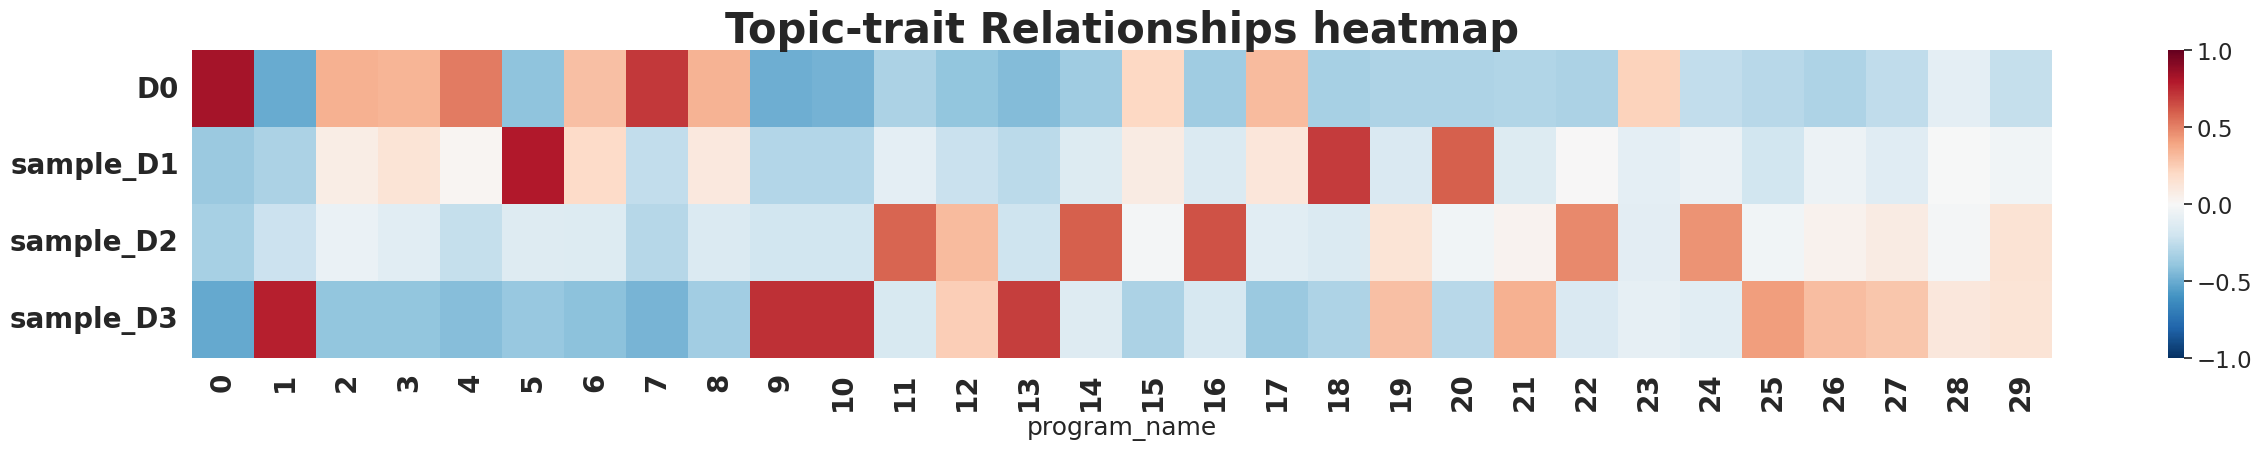

In [97]:
plot_topic_trait_relationship_heatmap(
    cell_membership, 
    obs,
    covariates=["sample"],
    annotation=False
)